# Taylor Diagrams

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import regionmask
import dask
import xarray as xr
import numpy as np
from cartopy import crs as ccrs
from dask.distributed import Client
from evaltools import obs, eval
import intake

dask.config.set(scheduler="single-threaded")

In [3]:
client = Client(dashboard_address="localhost:8787")
client

<Client: 'tcp://127.0.0.1:38237' processes=4 threads=16, memory=125.79 GiB>

In [4]:
catalog = intake.open_esm_datastore("https://raw.githubusercontent.com/euro-cordex/joint-evaluation/refs/heads/main/CORDEX-CMIP6.json")
catalog.keys()

['CORDEX.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1.fx.orog.v20241120',
 'CORDEX.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1.fx.sftlf.v20241120',
 'CORDEX.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1.mon.pr.v20241120',
 'CORDEX.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1.mon.psl.v20241120',
 'CORDEX.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1.mon.tas.v20241120',
 'CORDEX.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1.mon.tasmax.v20241120',
 'CORDEX.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1.mon.tasmin.v20241120']

In [6]:
dataset_dict = catalog.search(variable_id=["tas", "orog", "sftlf"]).to_dataset_dict(xarray_open_kwargs={"use_cftime": True, "decode_coords": "all"})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.variable_id.version'


/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarr

2024-12-05 22:28:03,879 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:41009' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'_open_dataset-071d9928-b724-4450-b1b8-bc181573b212'} (stimulus_id='handle-worker-cleanup-1733437683.8795478')
2024-12-05 22:28:03,882 - distributed.scheduler - ERROR - Couldn't gather keys: {'_open_dataset-071d9928-b724-4450-b1b8-bc181573b212': 'processing'}
2024-12-05 22:28:03,890 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling ('_open_dataset-071d9928-b724-4450-b1b8-bc181573b212',)
2024-12-05 22:28:03,893 - distributed.nanny - WARNING - Restarting worker


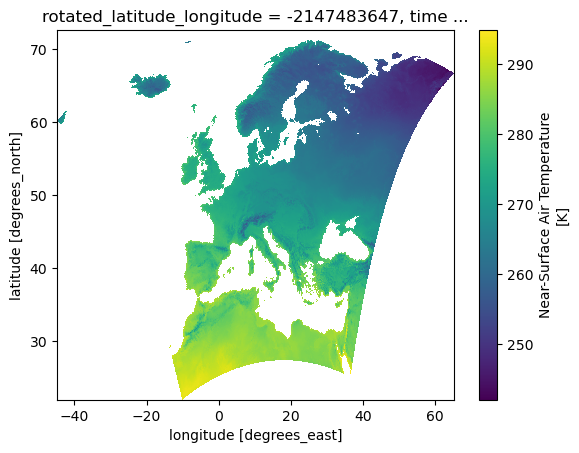

In [9]:
import xarray as xr

time_range = slice("1979", "2020")

ds = xr.merge(dataset_dict.values()).sel(time=time_range)
ds["tas"] = ds.tas.where(ds.sftlf > 0)
ds.tas.isel(time=0).plot(x="lon", y="lat")

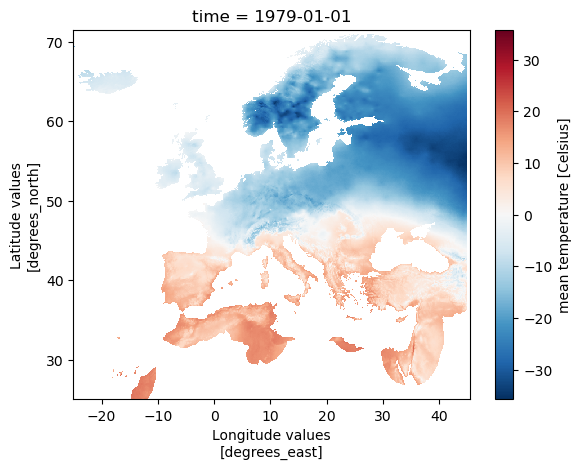

In [10]:
eobs = obs.eobs().sel(time=time_range)
eobs.isel(time=0).tg.plot()

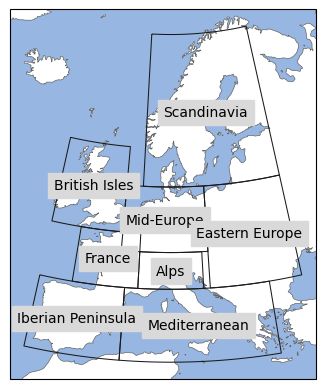

In [11]:
import regionmask
from cartopy import crs as ccrs

prudence = regionmask.defined_regions.prudence

proj = ccrs.LambertConformal(central_longitude=10)
ax = prudence.plot(
    add_ocean=True,
    projection=proj,
    resolution="50m",
    label="name",
    line_kws=dict(lw=0.75),
)

In [12]:
mask_prudence = prudence.mask_3D(ds.lon, ds.lat)
weights = np.cos(np.deg2rad(ds.rlat))
tas_regional = ds.tas.weighted(mask_prudence * weights).mean(dim=("rlat", "rlon"))

In [13]:
%%time
tas_regional_ = tas_regional.compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 10.95 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 2.39 s, sys: 151 ms, total: 2.54 s
Wall time: 3.4 s


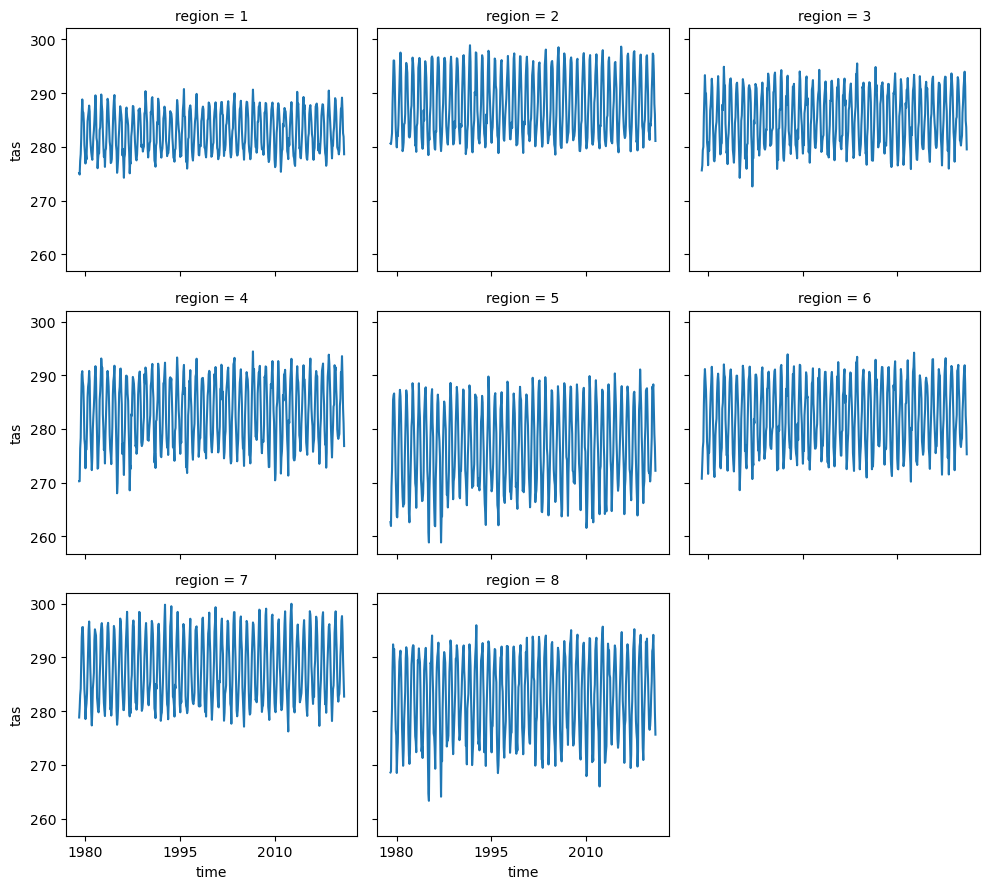

In [14]:
tas_regional_.plot(col="region", col_wrap=3)

In [ ]:
mask_prudence = prudence.mask_3D(eobs)
weights = np.cos(np.deg2rad(eobs.cf["X"]))

In [ ]:
%%time
eobs_monthly = eobs.resample(time="MS").mean().compute()

CPU times: user 33.4 s, sys: 9.71 s, total: 43.1 s
Wall time: 2min 22s


In [19]:
%%time
eobs_regional = eobs_monthly.cf.weighted(mask_prudence * weights).mean(dim=("X", "Y"))

CPU times: user 13.7 s, sys: 591 ms, total: 14.3 s
Wall time: 12.9 s


In [21]:
tas_regional

<xarray.DataArray 'tas' (time: 504, region: 8)> Size: 32kB
dask.array<truediv, shape=(504, 8), dtype=float64, chunksize=(1, 8), chunktype=numpy.ndarray>
Coordinates:
    rotated_latitude_longitude  int32 4B -2147483647
  * time                        (time) object 4kB 1979-01-16 12:00:00 ... 202...
    height                      float64 8B 2.0
  * region                      (region) int64 64B 1 2 3 4 5 6 7 8
    abbrevs                     (region) <U2 64B 'BI' 'IP' 'FR' ... 'MD' 'EA'
    names                       (region) <U17 544B 'British Isles' ... 'Easte...

In [23]:
tas_regional["time"] = eobs_regional.time

In [33]:
%%time
std_norm  = (tas_regional.std("time") / eobs_regional.tg.std("time")).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 10.97 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3.31 s, sys: 141 ms, total: 3.45 s
Wall time: 4.09 s


In [34]:
%%time
corr= xr.corr(eobs_regional.tg, tas_regional, dim="time").compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 11.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 7.42 s, sys: 310 ms, total: 7.73 s
Wall time: 8.98 s


In [44]:
std_norm.names.values.tolist()

['British Isles',
 'Iberian Peninsula',
 'France',
 'Mid-Europe',
 'Scandinavia',
 'Alps',
 'Mediterranean',
 'Eastern Europe']

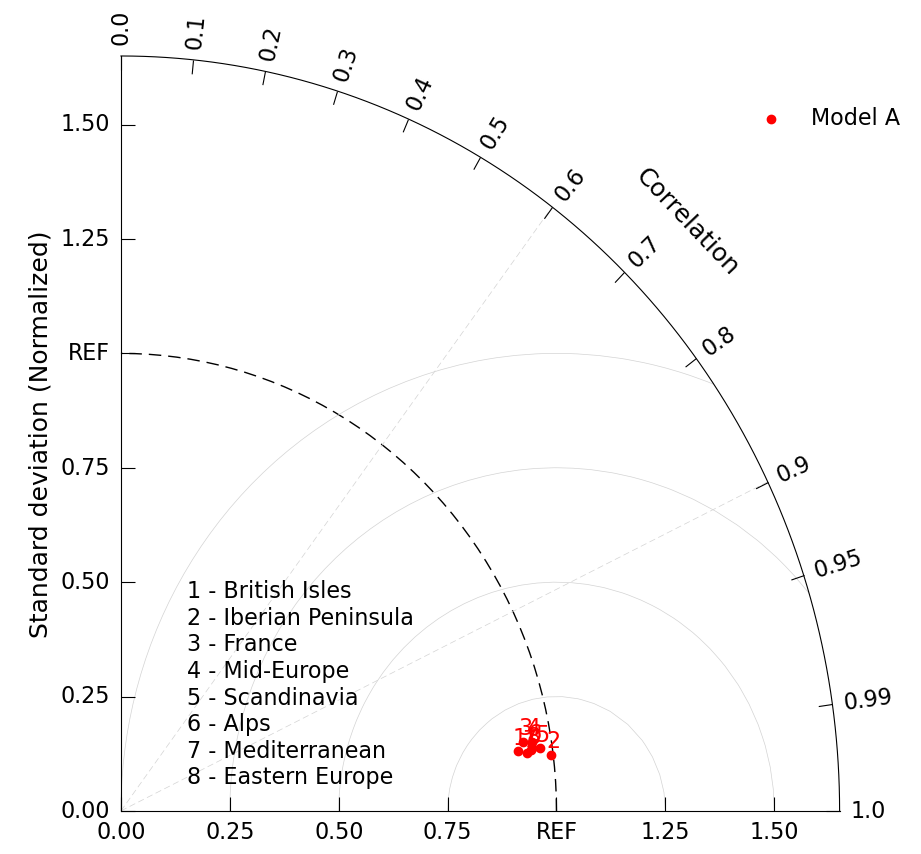

In [45]:
import matplotlib.pyplot as plt
import geocat.viz as gv

# Create figure and TaylorDiagram instance
fig = plt.figure(figsize=(10, 10))
taylor = gv.TaylorDiagram(fig=fig, label='REF')

# Draw diagonal dashed lines from origin to correlation values
# Also enforces proper X-Y ratio
taylor.add_xgrid(np.array([0.6, 0.9]))

# Add models to Taylor diagram
taylor.add_model_set(std_norm,
                  corr,
                  color='red',
                  marker='o',
                  label='Model A', # add model set legend label
                  fontsize=16)

# Add model name
taylor.add_model_name(std_norm.names.values.tolist(), fontsize=16)

# Add figure legend
taylor.add_legend(fontsize=16)

# Add constant centered RMS difference contours.
taylor.add_contours(levels=np.arange(0, 1.1, 0.25),
                 colors='lightgrey',
                 linewidths=0.5);